In [16]:
# All includes

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import metrics
import pandas as pd

import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# for svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC

# Current best:
# Decision Tree: 99/91%


## Current Best for SVM: no frequency features
# window_size: 12
# Stridee: 5
# Overall Accuracy: 90/90


# if frequency involved --> achieve 91/89 accuracy

In [17]:
# Import data

df = pd.read_excel('data.xlsx')

df = df.drop(columns=['Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23'])

#df.head()

In [18]:
# Prepare data

#df.columns

Feeding = df[['Feeding', 'Unnamed: 1', 'Unnamed: 2']]
Feeding = Feeding.dropna()
Feeding.index = pd.RangeIndex(len(Feeding.index))
Feeding = Feeding.drop(0)

Lying = df[['Lying', 'Unnamed: 4', 'Unnamed: 5']]
Lying = Lying.dropna()
Lying.index = pd.RangeIndex(len(Lying.index))
Lying = Lying.drop(0)

Standing = df[['Standing', 'Unnamed: 7', 'Unnamed: 8']]
Standing = Standing.dropna()
Standing.index = pd.RangeIndex(len(Standing.index))
Standing = Standing.drop(0)

Lying_down = df[['Lying down', 'Unnamed: 10', 'Unnamed: 11']]
Lying_down = Lying_down.dropna()
Lying_down.index = pd.RangeIndex(len(Lying_down.index))
Lying_down = Lying_down.drop(0)

Standing_up = df[['Feeding', 'Unnamed: 13', 'Unnamed: 14']]
Standing_up = Standing_up.dropna()
Standing_up.index = pd.RangeIndex(len(Standing_up.index))
Standing_up = Standing_up.drop(0)

Normal_walking = df[['Normal walking', 'Unnamed: 16', 'Unnamed: 17']]
Normal_walking = Normal_walking.dropna()
Normal_walking.index = pd.RangeIndex(len(Normal_walking.index))
Normal_walking = Normal_walking.drop(0)

Active_walking = df[['Active walking', 'Unnamed: 19', 'Unnamed: 20']]
Active_walking = Active_walking.dropna()
Active_walking.index = pd.RangeIndex(len(Active_walking.index))
Active_walking = Active_walking.drop(0)

#Active_walking.columns

In [19]:
#Standing.head(10)

In [52]:
## compute feature database
prepared_features = []
window_size = 12
stride = 3
# current best:
# window_size = 15   or 12
# stride = 6         or 5

# windowing and overlaping
#test_data = Standing.loc[15]

Feeding_data_list = [Feeding[i:i+window_size] for i in range(0, len(Feeding), stride) if i+window_size<=len(Feeding)]

Lying_data_list = [Lying[i:i+window_size] for i in range(0, len(Lying), stride) if i+window_size<=len(Lying)]

Lying_down_data_list = [Lying_down[i:i+window_size] for i in range(0, len(Lying_down), stride) if i+window_size<=len(Lying_down)]

Standing_data_list = [Standing[i:i+window_size] for i in range(0, len(Standing), stride) if i+window_size<=len(Standing)]

Standing_up_data_list = [Standing_up[i:i+window_size] for i in range(0, len(Standing_up), stride) if i+window_size<=len(Standing_up)]

Normal_walking_data_list = [Normal_walking[i:i+window_size] for i in range(0, len(Normal_walking), stride) if i+window_size<=len(Normal_walking)]

Active_walking_data_list = [Active_walking[i:i+window_size] for i in range(0, len(Active_walking), stride) if i+window_size<=len(Active_walking)]


In [53]:
# include lib for frequency domain features computations
from scipy import signal

In [54]:
# this function extract vector of features from raw data
# Expected features:
# 1. mean
# 2. median
# 3. variance
# 4. range
# 5. standard Deviation
# 6. average
# ---------------------------
# 7. energy
# 8. correlation
# 9. velocity
# 10. acceleration
# 11. fundamental frequencies (DFT)
# 12. signal peaks (using PSD - Power Spectral Density) 
# todo:...
# spectral peak features (12 per channel): value and freq of first 6 peaks
# for each chanel: x,  y, z:
# ---> expecting to extract 12 features:
# features  1-6: position of the highest 6 peaks
# features 7-12: power levels of the highest 6 peaks

# return feat: a numpy array of length 18 <todo>

def featuresFromBuffer(at, fs):
    feat = np.zeros(63)
    #feat = []
    x = np.array(at.iloc[:,0], dtype=np.float64)   # x acceleration component
    y = np.array(at.iloc[:,1], dtype=np.float64)   # y
    z = np.array(at.iloc[:,2], dtype=np.float64)   # z
    #print(len(x))
    # Average value in signal buffer for all three acceleration components (1 each)    
    means = [np.mean(i) for i in [x, y, z]]
    feat[0:3] = means
    
    # RMS value in signal buffer for all three acceleration components (1 each)
    rms = [np.sqrt(np.mean(i**2)) for i in [x, y, z]]
    feat[3:6] = rms
    
    # Standard deviation
    std = [np.std(i) for i in [x, y, z]]
    feat[6:9] = std
    
    # Variance
    var = [np.var(i) for i in [x, y, z]]
    feat[9:12] = var
    
    # Median
    med = [np.median(i) for i in [x, y, z]]
    feat[12:15] = med
    
    # Range
    Range1 = [ np.amin(i) for i in [x, y, z]]    
    feat[15:18] = Range1
    Range2 = [ np.amax(i) for i in [x, y, z]]    
    feat[18:21] = Range2
    
    # Energy
    #energy = [ sum(i**2) for i in [x, y, z]]
    #feat[39:42] = energy
    
    # Power Spectral Density
    psd = []
    for i in [x, y, z]:
        f, p = signal.welch(i)
        pp = p.tolist()
        ff = f.tolist()
        for ppp in pp:
            psd.append(ppp)
        for fff in ff:
            psd.append(fff)
        #psd.append(pp)
        #print(psd)
    feat[21:63] = psd
# window_side*2    
# TODO:
    # Spectral peak features
    # Spectral power features
    # Autocorrelation features
    
    return feat
      

In [55]:
## Definitons:
# Feeding: 1
# Lying: 2
# Standing: 3
# Lying down: 4
# Standing up: 5
# Normal walking: 6
# Active walking: 7

#data = [Feeding, Lying, Standing, Lying_down, Standing, Lying_down, Standing_up, Normal_walking, Active_walking]
# features_vector is a list of numpy arrays
features_vector = []

lables = []

#len(Feeding_data_list)
#Feeding_data_list[1226]
#Feeding

In [56]:
print("begin->end")
# main loop of data preparation
i = 0

# Add Feeding feature and lable = 1
for action in Feeding_data_list:
    feat = featuresFromBuffer(action, 5)
    features_vector.append(feat)
    lables.append(1)

# Add Lying feature and lable = 2
for action in Lying_data_list:
    feat = featuresFromBuffer(action, 5)
    features_vector.append(feat)
    lables.append(2)
    
# Add Standing feature and lable = 3
for action in Standing_data_list:
    feat = featuresFromBuffer(action, 5)
    features_vector.append(feat)
    lables.append(3)
    
# Add Lying_down feature and lable = 4
for action in Lying_down_data_list:
    feat = featuresFromBuffer(action, 5)
    features_vector.append(feat)
    lables.append(4)
    
# Add Standing_up feature and lable = 5
for action in Standing_up_data_list:
    feat = featuresFromBuffer(action, 5)
    features_vector.append(feat)
    lables.append(5)
    
# Add Normal_walking feature and lable = 6
for action in Normal_walking_data_list:
    feat = featuresFromBuffer(action, 5)
    features_vector.append(feat)
    lables.append(6)
    
# Add Active_walking feature and lable = 7
for action in Active_walking_data_list:
    feat = featuresFromBuffer(action, 5)
    features_vector.append(feat)
    lables.append(7)

    
    

begin->end


/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/p

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/p

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/p

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/p

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/p

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/p

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/p

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/p

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/p

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/p

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/p

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/p

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/p

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/p

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/p

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/p

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/p

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/p

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/p

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/p

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/p

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/p

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/p

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/p

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/p

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/p

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/p

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/p

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/p

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/p

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/p

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/p

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/p

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/p

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/p

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/p

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/p

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/p

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/p

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/p

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/p

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/p

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/p

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/p

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/p

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/p

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/p

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/p

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/p

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/p

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/p

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/p

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/p

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/p

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/p

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/p

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/p

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/p

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/p

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/p

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/p

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/p

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/p

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/p

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/p

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/p

/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 12, using nperseg = 12
  .format(nperseg, input_length))
/home/kikyou/.local/lib/p

In [57]:
# prepare data train;
X_train, X_test,y_train, y_test = train_test_split(features_vector, lables, test_size=0.4, random_state=0)

In [58]:
len(features_vector)

len(lables)

7349

7349

In [59]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler()
clf = MLPClassifier(hidden_layer_sizes = [100, 100], alpha = 4.0,
                   random_state = 0, solver='lbfgs').fit(X_train, y_train)

print('Accuracy of NN classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of NN classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))


Accuracy of NN classifier on training set: 0.91
Accuracy of NN classifier on test set: 0.89


In [60]:
from sklearn.tree import DecisionTreeClassifier
from adspy_shared_utilities import plot_decision_tree

clf1 = DecisionTreeClassifier().fit(X_train, y_train)

print('Accuracy of Decision Tree classifier on training set: {:.3f}'
     .format(clf1.score(X_train, y_train)))
print('Accuracy of Decision Tree classifier on test set: {:.3f}'
     .format(clf1.score(X_test, y_test)))

Accuracy of Decision Tree classifier on training set: 0.978
Accuracy of Decision Tree classifier on test set: 0.881


In [15]:
# Setting max decision tree depth to help avoid overfitting
# LOL
# best 24/21
clf2 = DecisionTreeClassifier(max_depth = 5).fit(X_train, y_train)

print('Accuracy of Decision Tree classifier on training set: {:.3f}'
     .format(clf2.score(X_train, y_train)))
print('Accuracy of Decision Tree classifier on test set: {:.3f}'
     .format(clf2.score(X_test, y_test)))

Accuracy of Decision Tree classifier on training set: 0.859
Accuracy of Decision Tree classifier on test set: 0.855


In [154]:
feature_names = ['mean in x dimension', 'mean in y dimension', 'mean in z dimension', 
                 'rms in x dimension', 'rms in y dimension', 'rms in z dimension',
                'std in x dimension', 'std in y dimension', 'std in z dimension',
                'var in x dimension', 'var in y dimension', 'var in z dimension',
                'min_range_value in x dimension', 'min_range_value in y dimension', 'min_range_value in z dimension',
                'max_range_value in x dimension', 'max_range_value in y dimension', 'max_range_value in z dimension',
                'psd_1 in x dimension', 'psd_2 in x dimension', 'psd_3 in x dimension', 'psd_4 in x dimension', 'psd_5 in x dimension', 'psd_6 in x dimension', 'psd_7 in x dimension',
                'f_1 in x dimension', 'f_2 in x dimension', 'f_3 in x dimension', 'f_4 in x dimension', 'f_5 in x dimension', 'f_6 in x dimension', 'f_7 in x dimension',
                'psd_1 in y dimension', 'psd_2 in y dimension', 'psd_3 in y dimension', 'psd_4 in y dimension', 'psd_5 in y dimension', 'psd_6 in y dimension', 'psd_7 in y dimension',
                'f_1 in y dimension', 'f_2 in y dimension', 'f_3 in y dimension', 'f_4 in y dimension', 'f_5 in y dimension', 'f_6 in y dimension', 'f_7 in y dimension',
                'psd_1 in z dimension', 'psd_2 in z dimension', 'psd_3 in z dimension', 'psd_4 in z dimension', 'psd_5 in z dimension', 'psd_6 in z dimension', 'psd_7 in z dimension',
                'f_1 in z dimension', 'f_2 in z dimension', 'f_3 in z dimension', 'f_4 in z dimension', 'f_5 in z dimension', 'f_6 in z dimension', 'f_7 in z dimension'              
                ]

target_names = { 'Feeding',
                 'Lying',
                 'Standing'
                 'Lying down'
                 'Standing up'
                 'Normal walking'
                 'Active walking'
}

In [14]:
#todo:
#from adspy_shared_utilities import plot_feature_importances
#plt.figure(figsize=(10, 4))
#plot_feature_importances(clf2, feature_names)
#plt.show()
print('Feature importances: {}'.format(clf2.feature_importances_))

#plot_decision_tree(clf2, features_vector, lables)

NameError: name 'clf2' is not defined

In [156]:
#Visualizing decision trees

#from sklearn.tree import DecisionTreeClassifier
#from adspy_shared_utilities import plot_class_regions_for_classifier_subplot

#X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state = 0)
#fig, subaxes = plt.subplots(6, 1, figsize=(6, 32))

#pair_list = [[0,1], [0,2], [0,3], [1,2], [1,3], [2,3]]
#tree_max_depth = 4

#for pair, axis in zip(pair_list, subaxes):
#    X = X_train
#    y = y_train
    
#    clf = DecisionTreeClassifier(max_depth=tree_max_depth).fit(X, y)
#    title = 'Decision Tree, max_depth = {:d}'.format(tree_max_depth)
#    plot_class_regions_for_classifier_subplot(clf, X, y, None,
#                                             None, title, axis,
#                                             iris.target_names)
    
#    axis.set_xlabel(iris.feature_names[pair[0]])
#    axis.set_ylabel(iris.feature_names[pair[1]])
    
#plt.tight_layout()
#plt.show()

In [157]:
# Gradient Boosted Decision Trees
from sklearn.ensemble import GradientBoostingClassifier

clf3 = GradientBoostingClassifier().fit(X_train, y_train)

print('Accuracy of GBDT classifier on training set: {:.3f}'
     .format(clf3.score(X_train, y_train)))
print('Accuracy of GBDT classifier on test set: {:.3f}'
     .format(clf3.score(X_test, y_test)))

Accuracy of GBDT classifier on training set: 0.954
Accuracy of GBDT classifier on test set: 0.929


In [ ]:
clf4 = GradientBoostingClassifier(learning_rate=0.18595, max_depth=5).fit(X_train, y_train)

print('Accuracy of GBDT classifier on training set: {:.3f}'
     .format(clf4.score(X_train, y_train)))
print('Accuracy of GBDT classifier on test set: {:.3f}'
     .format(clf4.score(X_test, y_test)))

# best: 0.18595  learning rate -> 91,4 %
# max_depth = 5

In [ ]:
len(X_test)
len(y_train)

In [123]:
# make color
import seaborn as sns
from matplotlib import cm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

<Figure size 1080x720 with 0 Axes>

Text(0.5, 1.0, 'Decision Tree \nAccuracy:0.939')

Text(114.0, 0.5, 'True label')

Text(0.5, 69.0, 'Predicted label')

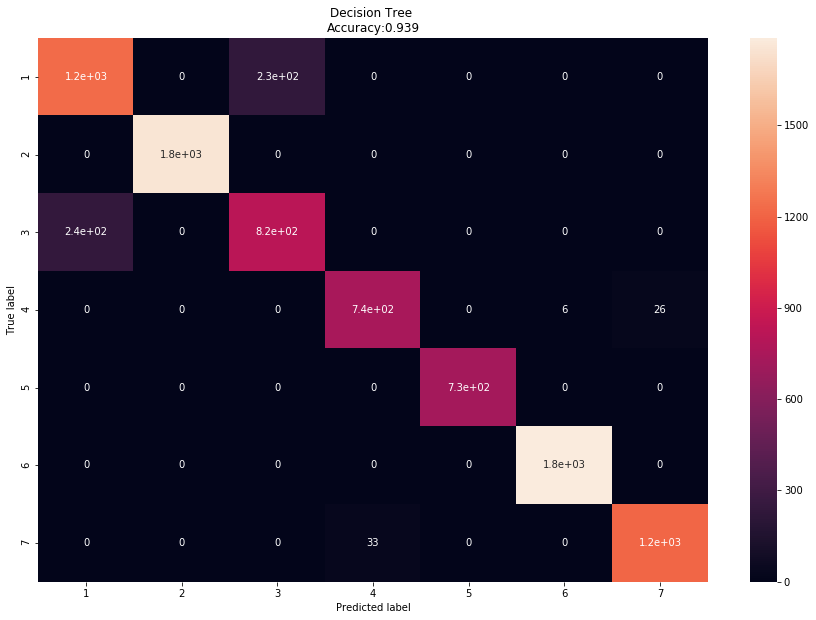

In [124]:
# confusion matrices:
predicted = clf4.predict(X_test)


confusion_test = confusion_matrix(y_test, predicted)


df_cm = pd.DataFrame(confusion_test,
                    index = [i for i in range(1, 8)], columns = [i for i in range(1, 8)])


plt.figure(figsize=(15,10))

sns.heatmap(df_cm, annot=True)

plt.title('Decision Tree \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, 
                                                                       predicted)))
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [125]:
print(classification_report(y_test, predicted))
# Accuracy is calculated follow vertically
# for example:
# accuracy for the 3rd status: 58/(58+23)

              precision    recall  f1-score   support

           1       0.84      0.84      0.84      1468
           2       1.00      1.00      1.00      1756
           3       0.78      0.77      0.77      1059
           4       0.96      0.96      0.96       775
           5       1.00      1.00      1.00       727
           6       1.00      1.00      1.00      1786
           7       0.98      0.97      0.98      1243

   micro avg       0.94      0.94      0.94      8814
   macro avg       0.94      0.94      0.94      8814
weighted avg       0.94      0.94      0.94      8814



In [126]:
## Definitons:
# Feeding: 1
# Lying: 2
# Standing: 3
# Lying down: 4
# Standing up: 5
# Normal walking: 6
# Active walking: 7

In [130]:
# Please ignore from this line forward

In [127]:
# Naive Bayes classifiers
from sklearn.naive_bayes import GaussianNB

nbclf = GaussianNB().fit(X_train, y_train)

print('Accuracy of GBDT classifier on training set: {:.3f}'
     .format(nbclf.score(X_train, y_train)))
print('Accuracy of GBDT classifier on test set: {:.3f}'
     .format(nbclf.score(X_test, y_test)))

Accuracy of GBDT classifier on training set: 0.815
Accuracy of GBDT classifier on test set: 0.812


In [128]:
# Random Forests
from sklearn.ensemble import RandomForestClassifier
clf5 = RandomForestClassifier(n_estimators=17, random_state=0).fit(X_train, y_train)

print('Accuracy of RF classifier on training set: {:.3f}'
     .format(clf5.score(X_train, y_train)))
print('Accuracy of RF classifier on test set: {:.3f}'
     .format(clf5.score(X_test, y_test)))


Accuracy of RF classifier on training set: 0.974
Accuracy of RF classifier on test set: 0.932


<Figure size 1080x720 with 0 Axes>

Text(0.5, 1.0, 'Decision Tree \nAccuracy:0.900')

Text(114.0, 0.5, 'True label')

Text(0.5, 69.0, 'Predicted label')

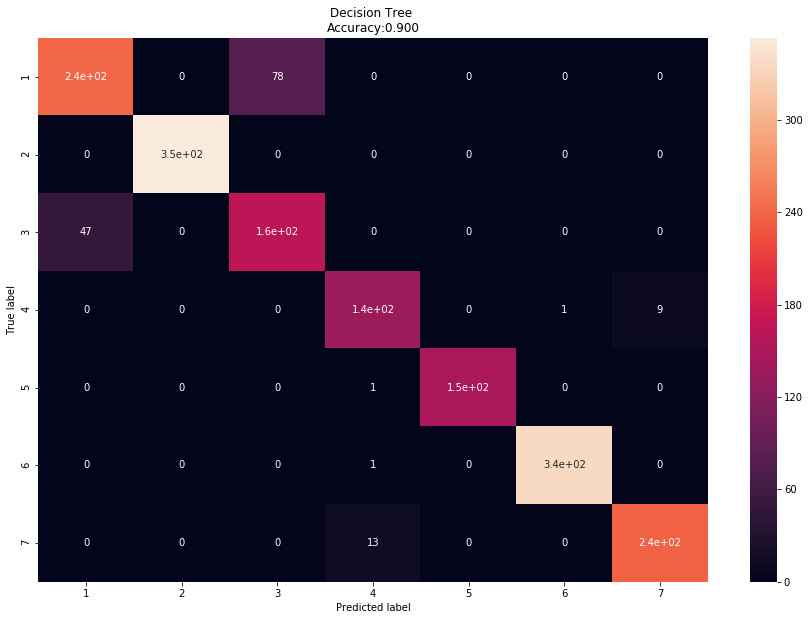

In [180]:
# confusion matrices:
predicted5 = clf5.predict(X_test)


confusion_test5 = confusion_matrix(y_test, predicted)


df_cm5 = pd.DataFrame(confusion_test5,
                    index = [i for i in range(1, 8)], columns = [i for i in range(1, 8)])


plt.figure(figsize=(15,10))

sns.heatmap(df_cm5, annot=True)

plt.title('Decision Tree \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, 
                                                                       predicted5)))
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [129]:
print('Feature importances: {}'.format(clf4.feature_importances_))

Feature importances: [0.00344461 0.00795357 0.00360394 0.14469192 0.06124205 0.04273706
 0.06824263 0.02107522 0.03694089 0.02279349 0.0043241  0.01414912
 0.00033966 0.00115951 0.11201444 0.00101795 0.00620293 0.16139343
 0.0309072  0.00301874 0.20928863 0.00097131 0.00278847 0.0011762
 0.00335016 0.00270918 0.00145566 0.0014699  0.         0.
 0.         0.         0.         0.         0.         0.00200283
 0.00473413 0.00168202 0.00160234 0.00180612 0.00210678 0.00136128
 0.         0.         0.         0.         0.         0.
 0.         0.00089856 0.00258895 0.00314366 0.00290515 0.00159074
 0.00170452 0.00141095 0.         0.         0.         0.
 0.         0.         0.        ]
